In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import argparse
import torch
import pandas as pd
import net
import spacy
import numpy as np
from visualize import visualize
from IPython.display import Image
from IPython.display import display
from preprocessing import read_data, sentence_reader
from tools import revert_mapping
from forest import calc_embedding
from scipy.spatial.distance import cosine

In [2]:
# load evaluation data
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('/home/arne/devel/ML/data/corpora/SICK/sick_test_annotated/SICK_test_annotated_edited.txt', delimiter='\t')
df = df.set_index(['pair_ID'])
df[['entailment_judgment']] = df[['entailment_judgment']].astype(str)
df[['relatedness_score_gold']] = df[['relatedness_score']]
# filter by entailment
# df = df[(df.entailment_judgment == 'ENTAILMENT')]

df[['sentence_A','sentence_B','relatedness_score', 'entailment_judgment']].to_csv('~/devel/ML/data/corpora/SICK/scores_gold.txt', sep='\t', encoding='utf-8')
df

,sentence_A,sentence_B,relatedness_score,entailment_judgment,relatedness_score_gold
pair_ID,,,,,
10,A brown dog is attacking another animal in front of the tall man in pants,A brown dog is attacking another animal in front of the man in pants,4.900,ENTAILMENT,4.900
19,A person in a black jacket is doing tricks on a motorbike,A man in a black jacket is doing tricks on a motorbike,4.900,ENTAILMENT,4.900
22,A skilled person is riding a bicycle on one wheel,A person is riding the bicycle on one wheel,4.300,ENTAILMENT,4.300
32,The game of basketball consists of a ball being dunked by a man with a jersey,A man with a jersey is dunking the ball at a basketball game,4.200,ENTAILMENT,4.200
33,A man who is playing dunks the basketball into the net and a crowd is in background,The player is dunking the basketball into the net and a crowd is in background,4.700,ENTAILMENT,4.700
41,Two people are kickboxing and spectators are watching,Two people are fighting and spectators are watching,4.400,ENTAILMENT,4.400
52,Kids in red shirts are playing in the leaves,Children in red shirts are playing in the leaves,4.900,ENTAILMENT,4.900
63,Two children are lying in the snow and are drawing angels,Two children are lying in the snow and are making snow angels,4.400,ENTAILMENT,4.400
66,Two people wearing snowsuits are on the ground making snow angels,Two people in snowsuits are lying in the snow and making snow angels,4.800,ENTAILMENT,4.800


In [3]:
# load model
net = torch.load('/home/arne/ML/data/summaries/train_2017-02-03_15:54:26/model-04')
data_maps_reverse = {}
for key in net.data_maps:
    data_maps_reverse[key] = revert_mapping(net.data_maps[key])
    

In [4]:
nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.parser]

In [5]:
def calc_sentence_embedding(sentence, vis = False):
    seq_data, seq_types, seq_parents, seq_edges = read_data(sentence_reader, nlp, net.data_maps, max_forest_count=net.max_forest_count,
                  max_sen_length=net.slice_size, args={'sentence': sentence})
    
    try:
        embedding = calc_embedding(net, seq_data, seq_types, seq_parents, seq_edges)
    except AssertionError as e:
        visualize('forest_temp.png', (seq_data, seq_types, seq_parents, seq_edges), data_maps_reverse, nlp.vocab)
        img = Image('forest_temp.png')
        display(img)
        print(str(e) + ": '" + sentence + "'")
        return None
        
    if vis == True:
        visualize('forest_temp.png', (seq_data, seq_types, seq_parents, seq_edges), data_maps_reverse, nlp.vocab)
        img = Image('forest_temp.png')
        display(img)
   
    return embedding
        

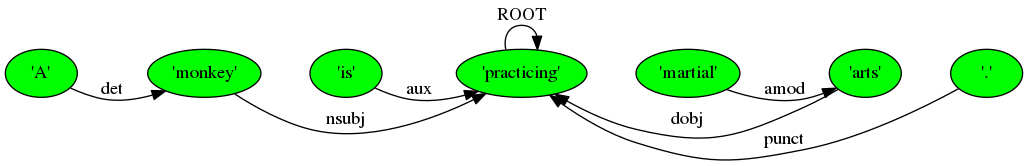

In [6]:
embedding_ref = calc_sentence_embedding('A monkey is practicing martial arts.', True)
#calc_sentence_embedding("A girl from Asia, in front of a brick window, doesn't look surprised.", True)

In [7]:
#i = 0
for row in df.itertuples():
    #if i == 3:
    #    break
    
    # create data arrays for sentence_A, visualize it and calc embedding
    embedding_A = calc_sentence_embedding(row.sentence_A + '.', False)
    #print(embedding_A)
    
    # create data arrays for sentence_A, visualize it and calc embedding
    embedding_B = calc_sentence_embedding(row.sentence_B + '.', False)
    #print(embedding_B)
    
    if embedding_A is not None and embedding_B is not None:
        df.at[row.Index, 'relatedness_score_cos'] = cosine(embedding_A, embedding_B)
        df.at[row.Index, 'relatedness_score_ref_A'] = cosine(embedding_A, embedding_ref)
        df.at[row.Index, 'relatedness_score_ref_B'] = cosine(embedding_B, embedding_ref)
    #print(df.loc[row.Index])
    df.at[row.Index, 'entailment_judgment'] = 'NA'
    #i += 1

#print(i)
# df

In [8]:
m = df[['relatedness_score_cos']].min()[0]
d = (df[['relatedness_score_cos']].max() - m)[0]
print('min:', m)
print('dif:', d)

min: -1.86436549088e-07
dif: 1.81689376934


In [9]:
df['relatedness_score'] = df['relatedness_score_cos'].subtract(m).divide(d).multiply(4).add(1)
m = df[['relatedness_score']].min()
d = df[['relatedness_score']].max() - m
print('min:', m)
print('dif:', d)

min: relatedness_score    1.0
dtype: float64
dif: relatedness_score    4.0
dtype: float64


In [10]:
df

,sentence_A,sentence_B,relatedness_score,entailment_judgment,relatedness_score_gold,relatedness_score_cos,relatedness_score_ref_A,relatedness_score_ref_B
pair_ID,,,,,,,,
10,A brown dog is attacking another animal in front of the tall man in pants,A brown dog is attacking another animal in front of the man in pants,1.311330,NA,4.900,1.414130e-01,0.404429,0.887834
19,A person in a black jacket is doing tricks on a motorbike,A man in a black jacket is doing tricks on a motorbike,1.000010,NA,4.900,4.167967e-06,0.002539,0.002543
22,A skilled person is riding a bicycle on one wheel,A person is riding the bicycle on one wheel,1.000209,NA,4.300,9.478766e-05,0.236275,0.242889
32,The game of basketball consists of a ball being dunked by a man with a jersey,A man with a jersey is dunking the ball at a basketball game,1.000360,NA,4.200,1.631717e-04,0.002994,0.002614
33,A man who is playing dunks the basketball into the net and a crowd is in background,The player is dunking the basketball into the net and a crowd is in background,1.011752,NA,4.700,5.337668e-03,0.002929,0.005166
41,Two people are kickboxing and spectators are watching,Two people are fighting and spectators are watching,1.000031,NA,4.400,1.398602e-05,0.002888,0.002906
52,Kids in red shirts are playing in the leaves,Children in red shirts are playing in the leaves,1.016701,NA,4.900,7.585956e-03,1.385887,1.305158
63,Two children are lying in the snow and are drawing angels,Two children are lying in the snow and are making snow angels,1.231905,NA,4.400,1.053364e-01,0.016534,0.182252
66,Two people wearing snowsuits are on the ground making snow angels,Two people in snowsuits are lying in the snow and making snow angels,1.000005,NA,4.800,2.014015e-06,0.002926,0.002933


In [11]:
df[['relatedness_score', 'entailment_judgment']].to_csv('~/devel/ML/data/corpora/SICK/my_test_scores.txt', sep='\t', encoding='utf-8')

In [12]:
# ~/devel/ML/data/corpora/SICK$ R --no-save --slave --vanilla --args my_test_scores.txt sick_test_annotated/SICK_test_annotated_edited.txt < sick_evaluation.R